In [71]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
import pandas as pd
from collections import Counter
import seaborn as sns

Unique cell types in the grid: [(np.int64(2), 'TypeObstacle'), (np.int64(4), 'TypeEmpty')]


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


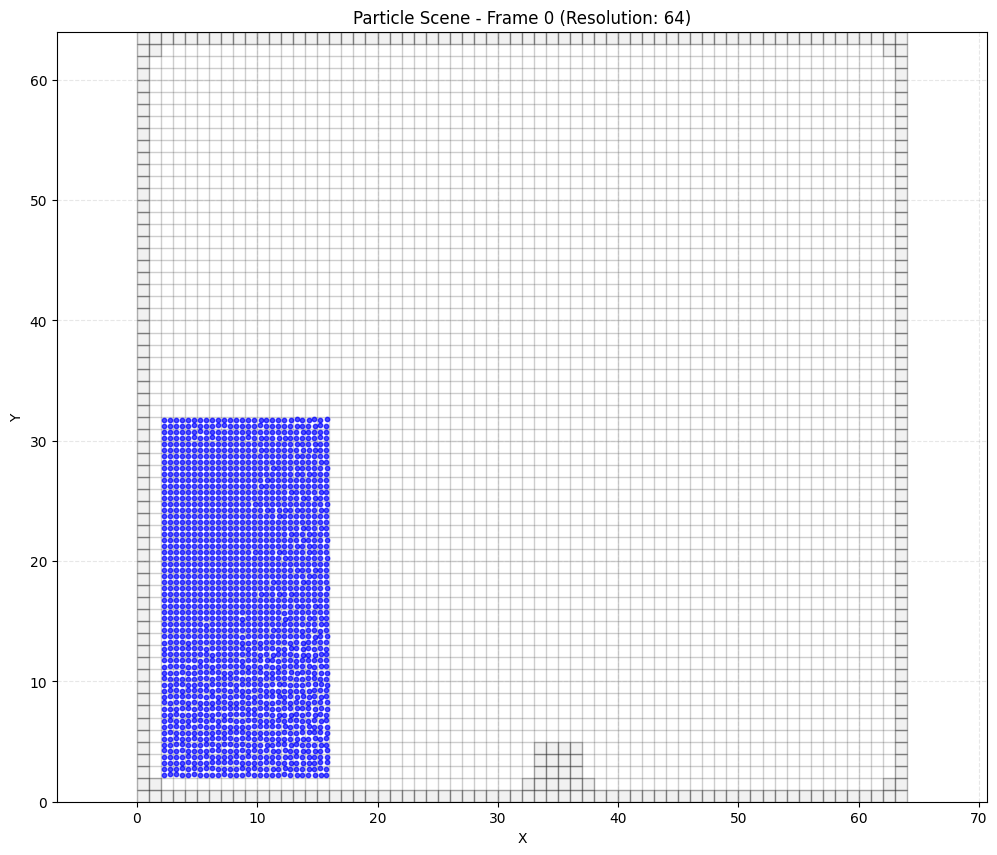

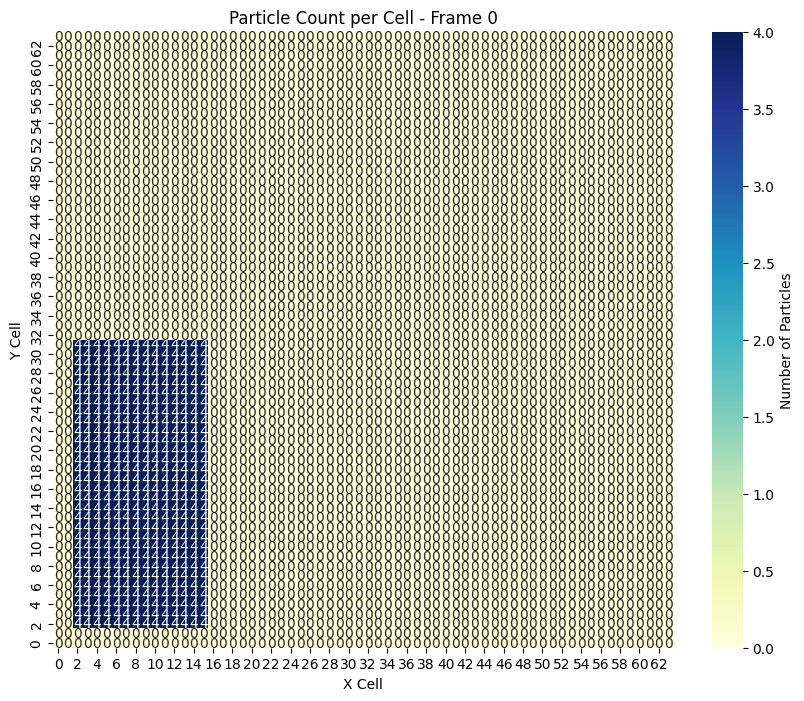

In [72]:
with open('./data/flip_obstacle.json', 'r') as f:
    data = json.load(f)

resolution = data['resolution']
frames = data['frames']

# Define the function to get cell type name from the integer value
def getFromType(type):
    match type:
        case 0:
            return "TypeNone"
        case 1:
            return "TypeFluid"
        case 2:
            return "TypeObstacle"
        case 4: 
            return "TypeEmpty"
        case 8:
            return "TypeInflow"
        case 16:
            return "TypeOutflow"
        case 32:
            return "TypeOpen"
        case 64:
            return "TypeStick"
    return "InternalType"

# Part 1: Visualize the first frame
frame = frames[0]
particles = frame['particles']
flags = frame['flags']

# Extract particle positions
particle_positions = np.array([p['pos'] for p in particles])

# Create a figure to visualize the scene
plt.figure(figsize=(12, 10))

# Draw the grid cells with their types
cell_size = 1.0
grid_height = len(flags)
grid_width = len(flags[0])

# Convert the flags grid to a 2D numpy array for easier processing
flags_array = np.array(flags)

# Create a colormap for different cell types
cell_types = np.unique(flags_array)
type_names = [getFromType(t) for t in cell_types]
print(f"Unique cell types in the grid: {list(zip(cell_types, type_names))}")

# Draw the grid with proper colors
for y in range(grid_height):
    for x in range(grid_width):
        cell_type = flags[y][x]
        color = 'lightgray' if cell_type == 2 else 'white'  # TypeObstacle is gray, others white
        alpha = 0.3 if cell_type == 2 else 0.1
        rect = patches.Rectangle((x*cell_size, y*cell_size), cell_size, cell_size, 
                                 linewidth=1, edgecolor='black', facecolor=color, alpha=alpha)
        plt.gca().add_patch(rect)

# Draw the particles
plt.scatter(particle_positions[:, 0], particle_positions[:, 1], s=10, c='blue', alpha=0.7)

plt.title(f"Particle Scene - Frame 0 (Resolution: {resolution})")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis('equal')
plt.grid(True, linestyle='--', alpha=0.3)
plt.xlim(0, grid_width * cell_size)
plt.ylim(0, grid_height * cell_size)
plt.show()

# Function to count particles in each cell
def count_particles_in_cells(particles, grid_width, grid_height, cell_size=1.0):
    # Initialize a 2D grid with zeros
    particle_counts = np.zeros((grid_height, grid_width), dtype=int)
    
    # Count particles in each cell
    for p in particles:
        pos = p['pos']
        # Convert position to grid coordinates
        x_cell = int(pos[0] / cell_size)
        y_cell = int(pos[1] / cell_size)
        
        # Ensure the position is within the grid bounds
        if 0 <= x_cell < grid_width and 0 <= y_cell < grid_height:
            particle_counts[y_cell, x_cell] += 1
    
    return particle_counts

# Count particles in each cell for the first frame
particle_counts = count_particles_in_cells(particles, grid_width, grid_height)

# Create a heatmap of particle distribution
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(particle_counts, annot=True, fmt="d", cmap="YlGnBu", cbar_kws={'label': 'Number of Particles'})
heatmap.invert_yaxis()
plt.title("Particle Count per Cell - Frame 0")
plt.xlabel("X Cell")
plt.ylabel("Y Cell")
plt.show()

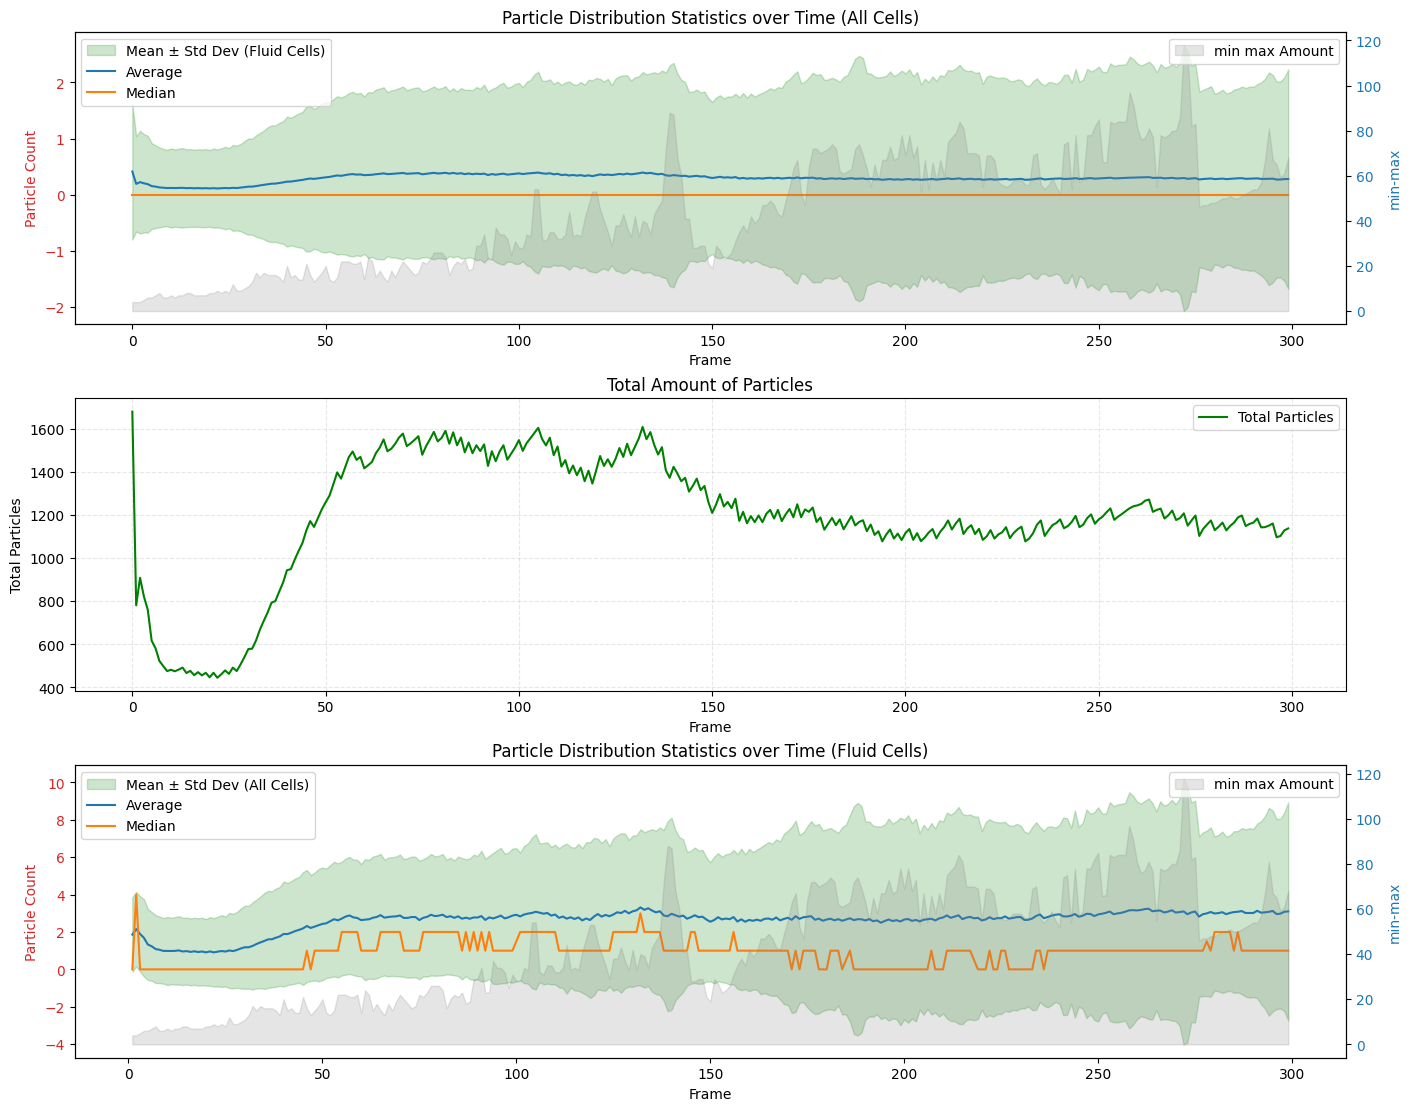


Summary Statistics for Mean and Standard Deviation:
Mean of Means (All): 0.2909
Mean of Std Devs (All): 1.5813
Std Dev of Means (All): 0.0702
Std Dev of Std Devs (All): 0.3662
Mean of Means (Fluid): 2.6010
Mean of Std Devs (Fluid): 4.0788
Std Dev of Means (Fluid): 0.5874
Std Dev of Std Devs (Fluid): 1.2055


In [ ]:
# Initialize lists to store statistics for each frame
frame_stats = []

# Process each frame
for i, frame in enumerate(frames):
    particles = frame['particles']
    flags = frame['flags']
    flags_array = np.array(flags)
    
    # Count particles in each cell
    particle_counts = count_particles_in_cells(particles, grid_width, grid_height)
    
    # Calculate statistics for all cells
    all_counts = particle_counts.flatten()
    stats = {
        "Frame": i,
        "Average (All)": np.mean(all_counts),
        "Std (All)": np.std(all_counts),
        "Median (All)": np.median(all_counts),
        "Min (All)": np.min(all_counts),
        "Max (All)": np.max(all_counts),
        "Total Particles": np.sum(all_counts)
    }
    
    # Calculate statistics only for TypeFluid cells (if any)
    fluid_cells = np.where(flags_array == 1)
    if len(fluid_cells[0]) > 0:
        fluid_counts = particle_counts[fluid_cells]
        stats.update({
            "Average (Fluid)": np.mean(fluid_counts),
            "Std (Fluid)": np.std(fluid_counts),
            "Median (Fluid)": np.median(fluid_counts),
            "Min (Fluid)": np.min(fluid_counts),
            "Max (Fluid)": np.max(fluid_counts),
            "Total Particles (Fluid)": np.sum(fluid_counts)
        })
    
    frame_stats.append(stats)

# Convert to DataFrame for easier analysis
stats_df = pd.DataFrame(frame_stats)


# Plot average and median for all cells
fig, axd = plt.subplot_mosaic([["up"], ["middle"], ["down"]], layout="constrained", figsize=(14, 10))
color = "tab:red"
axd["up"].set_title("Particle Distribution Statistics over Time (All Cells)")
axd["up"].set_xlabel('Frame')
axd["up"].set_ylabel('Particle Count', color=color)
axd["up"].fill_between(range(len(frames)), 
                     [m - s for m, s in zip(stats_df["Average (All)"], stats_df["Std (All)"])],
                     [m + s for m, s in zip(stats_df["Average (All)"], stats_df["Std (All)"])],
                     color='green', alpha=0.2, label='Mean ± Std Dev (Fluid Cells)')
axd["up"].plot(stats_df['Frame'], stats_df['Average (All)'], label="Average")
axd["up"].plot(stats_df['Frame'], stats_df['Median (All)'], label='Median')
axd["up"].tick_params(axis='y', labelcolor=color)
axd["up"].legend(loc='upper left')  # legend for the left y-axis
# Second y-axis
ax2 = axd["up"].twinx()
color = 'tab:blue'
ax2.set_ylabel('min-max', color=color)
ax2.fill_between(stats_df['Frame'], stats_df['Min (All)'], stats_df['Max (All)'], 
                 color='gray', alpha=0.2, label='min max Amount')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')  # legend for the right y-axis

# Lower plot
axd["middle"].set_title("Total Amount of Particles")
axd["middle"].plot(stats_df['Frame'], stats_df['Total Particles'], 'g-', label='Total Particles')
axd["middle"].set_ylabel("Total Particles")
axd["middle"].set_xlabel("Frame")
axd["middle"].legend(loc='best')

# Add grid and show
axd["middle"].grid(True, linestyle='--', alpha=0.3)

# If there are fluid cells, plot statistics for them as well
if 'Average (Fluid)' in stats_df.columns:
    color = "tab:red"
    axd["down"].set_title("Particle Distribution Statistics over Time (Fluid Cells)")
    axd["down"].set_xlabel('Frame')
    axd["down"].set_ylabel('Particle Count', color=color)
    axd["down"].fill_between(range(len(frames)), 
               [m - s for m, s in zip(stats_df["Average (Fluid)"], stats_df["Std (Fluid)"])],
               [m + s for m, s in zip(stats_df["Average (Fluid)"], stats_df["Std (Fluid)"])],
               color='green', alpha=0.2, label='Mean ± Std Dev (All Cells)')
    axd["down"].plot(stats_df['Frame'], stats_df['Average (Fluid)'], label="Average")
    axd["down"].plot(stats_df['Frame'], stats_df['Median (Fluid)'], label='Median')
    axd["down"].tick_params(axis='y', labelcolor=color)
    axd["down"].legend(loc='upper left')  # legend for the left y-axis
    # Second y-axis
    ax2 = axd["down"].twinx()
    color = 'tab:blue'
    ax2.set_ylabel('min-max', color=color)
    ax2.fill_between(stats_df['Frame'], stats_df['Min (Fluid)'], stats_df['Max (Fluid)'], 
                     color='gray', alpha=0.2, label='min max Amount')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc='upper right')  # legend for the right y-axis

plt.show()

# Display descriptive statistics
print("\nSummary Statistics for Mean and Standard Deviation:")
summary_stats = {
    "Mean of Means (All)": np.mean(stats_df['Average (All)']),
    "Mean of Std Devs (All)": np.mean(stats_df['Std (All)']),
    "Std Dev of Means (All)": np.std(stats_df['Average (All)']),
    "Std Dev of Std Devs (All)": np.std(stats_df['Std (All)']),
}

if 'Average (Fluid)' in stats_df.columns:
    summary_stats.update({
        "Mean of Means (Fluid)": np.mean(stats_df['Average (Fluid)']),
        "Mean of Std Devs (Fluid)": np.mean(stats_df['Std (Fluid)']),
        "Std Dev of Means (Fluid)": np.std(stats_df['Average (Fluid)']),
        "Std Dev of Std Devs (Fluid)": np.std(stats_df['Std (Fluid)']),
    })

for key, value in summary_stats.items():
    print(f"{key}: {value:.4f}")

/tmp/ipykernel_25223/3888155503.py:28: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(selected_positions[i][:, 0], selected_positions[i][:, 1], s = 10, c = colors[i], alpha=0.7, label=str(math.floor(i * len(frames) / num_frames)))
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


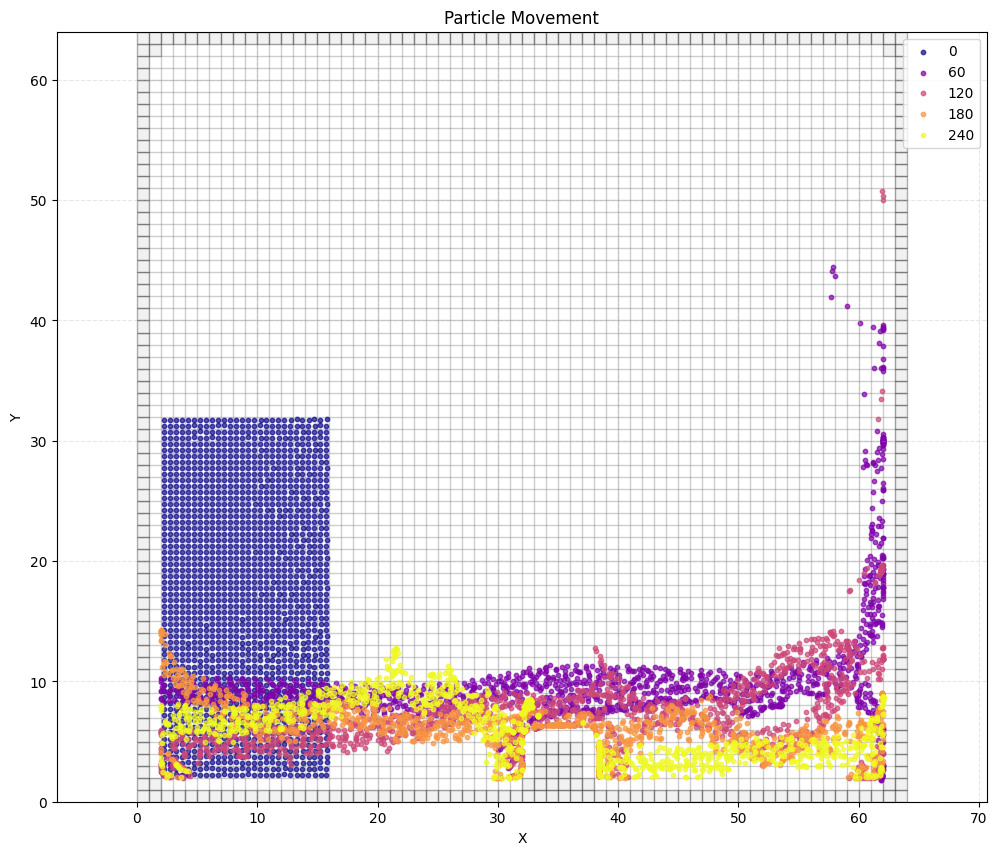

In [74]:
if len(frames) > 1:
    selected_frames = []
    num_frames = 5

    for i in range (num_frames):
        selected_frames.append(frames[math.floor(len(frames) / num_frames * i)])

    selected_positions = []

    for i in range(num_frames):
        selected_positions.append(np.array([p["pos"] for p in selected_frames[i]["particles"]]))
       
    plt.figure(figsize=(12, 10))
    
    # Draw the grid
    for y in range(grid_height):
        for x in range(grid_width):
            cell_type = selected_frames[0]['flags'][y][x]
            color = 'lightgray' if cell_type == 2 else 'white'
            alpha = 0.3 if cell_type == 2 else 0.1
            rect = patches.Rectangle((x*cell_size, y*cell_size), cell_size, cell_size, 
                                     linewidth=1, edgecolor='black', facecolor=color, alpha=alpha)
            plt.gca().add_patch(rect)
    
    cmap = plt.colormaps['plasma']
    colors = cmap(np.linspace(0, 1, num_frames))
    for i in range(num_frames):
        plt.scatter(selected_positions[i][:, 0], selected_positions[i][:, 1], s = 10, c = colors[i], alpha=0.7, label=str(math.floor(i * len(frames) / num_frames))) 
    
    plt.title(f"Particle Movement")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.axis('equal')
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.xlim(0, grid_width * cell_size)
    plt.ylim(0, grid_height * cell_size)
    plt.legend()
    plt.show()